# Assignment 2
From Jrue Dai, Lucas Li, Pramod Manohar, Yuntian Tang, Yifei Wu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import distributions as iid
from scipy.stats import multivariate_normal
from scipy.stats import uniform,f,t,norm
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.integrate import dblquad
import statsmodels.api as sm

### Q1. Exercises

(1) True, $E[h(x)u] = E[E[h(x)u|x]] = E[h(x)E[u|X]] = E[h(x)0] = 0$ </br>
(2) Since $y=\alpha+\beta x+u,h(x)=x^3$, then $yx^3=\alpha x^3+\beta x^4+ux^3$, and we have $E[yx^3]=\alpha E[x^3]+\beta E[x^4]$</br>
The difference between this estimator and OLS is that OLS has the least variance. Usually we use OLS since it's BLUE, however, if the conditional mean doesn't make sense and the orthogonal condition $E[x^3u]$ make sense, we'll prefer cubic one.</br>
(3) Given independence,
$$
E[u|x]= \int u \frac{f(x,u)}{f(x)} du =\int u\frac{f(x)g(u)}{f(x)} du = \int ug(u)du = E[u]
$$
Given mean independence $E[u|x]=E[u]$</br>
Without loss of generality, we assume $u~U[-|x|,|x|]$. Then $E[u|X]=E[u]=0$</br>
However, it's obvious that $u$ and $v$ are not independent.</br>
(4) Given independence
$$
E[g(u)x] = \int \int g(u)xf(u,x)dudx = \int \int g(u)xf(x)f(u)dudx= \int xf(x)dx \int g(u)f(u) du = ExEg(u)
$$
(5)
$$
E[(y-\hat{y(X)})^2|X]=e[y^2|X]-2\hat{y(x)}E[y|x]+\hat{y(x)}^2\\
min_{\hat{y(X)}} E[(y-\hat{y(X)})^2|X]\\
F.O.C. -2E[y|X]+2\hat{y(X)}=0\\
\hat{y(X)}=E[y|X]= E[f(X,\beta)+u|X] = E[f(X,\beta)|X] + E[u|X] = E[f(X,\beta)|X]
$$
(6) If D is a binary random variable, then
$$
b^{IV}=\frac{cov(Y,D)}{cov(X,D)}\\
=\frac{E[(Y-\bar{Y})(D-\bar{D})]}{E[(X-\bar{X})(D-\bar{D})]}\\
=\frac{P(D=0)E[(Y-\bar{Y})(-\bar{D})|D=0)+P(D=1)E[(Y-\bar{Y})(1-\bar{D})|D=1)}{P(D=0)E[(X-\bar{X})(-\bar{D})|D=0)+P(D=1)E[(X-\bar{X})(1-\bar{D})|D=1)}\\
=\frac{(1-\bar{D})\bar{D}(E(\bar{Y}-Y|D=0)+E(\bar{Y}-Y|D=1))}{(1-\bar{D})\bar{D}(E(\bar{X}-X|D=0)+E(\bar{X}-X|D=1))}\\
=\frac{E(\bar{Y}-Y|D=0)+E(Y-\bar{Y}|D=1)}{E(\bar{X}-X|D=0)+E(X-\bar{X}|D=1)}\\
=\frac{E(Y_i|D_i=1)-E(Y_i|D_i=0)}{E(X_i|D_i=1)-E(X_i|D_i=0)}
$$
(7)
The fig is upload onto the github independently.

### Q2.Wright(1928)
First let's generate the data according to the following equations.
$$
   q_D = \alpha p + u\qquad q_S = \beta p + v\qquad q_D = q_S,
$$

In [44]:
def dgp(n,alpha,beta,miu,sigma):
    #disturbance
    u = iid.norm(loc=miu[0],scale=sigma[0,0])
    v = iid.norm(loc=miu[1],scale=sigma[1,1])
    
    pi = np.array([[-beta/(alpha-beta),-1/(alpha-beta)],[alpha/(alpha-beta), 1/(alpha-beta)]])
    
    U = np.c_[u.rvs(n), v.rvs(n)]
    df = pd.DataFrame(U@pi,columns=['q','p'])
    Udf = pd.DataFrame(U,columns=['u','v'])
    
    return df,Udf,u,v

In [47]:
n = 1000
alpha = -1
beta = 2
miu = np.array([2,-1])
sigma = np.array([[1/2,0],[0,2]])

df,Udf,u,v = dgp(n,alpha,beta,miu,sigma)

##### (1) Control
if we set $p=p_0$ </br>
Suppose $p_0=1$ here.

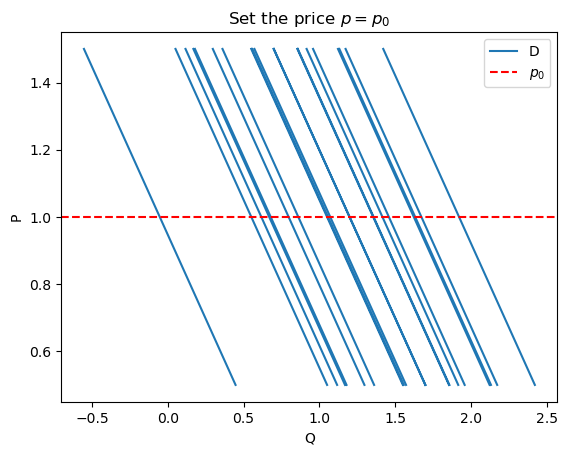

In [50]:
p0 = 1
Udf_plot = Udf.head(20)

# data for plotting
Q = pd.DataFrame({'min':alpha*(p0+0.5)+Udf_plot['u'],
                  'max':alpha*(p0-0.5)+Udf_plot['u'],
                  'skip':np.nan}) #np.nan is to prevent the connection between head and tail
D = Q.add(-Udf_plot['u'],axis=0)/alpha
control_plot =  pd.DataFrame({'Q':Q.stack(dropna=False),
                              'D':D.stack(dropna=False)})

control_plot.plot(x='Q')
plt.axhline(y = p0, color = 'r', linestyle = '--', label='$p_0$')
plt.ylabel('P')
plt.title('Set the price $p = p_0$')
plt.legend()
plt.show()

The calculation is as follows:
$E(q_D(p_0)) = \int_{}^{} q_D(p_0, u)dF_u(u)=\alpha p_0+E(u)$

In [51]:
# we try to realize the result
D_control = quad(lambda x:(alpha*p0+x)*u.pdf(x),-np.inf,np.inf)
D_control[0]

1.0000000000000002

##### (2) Condition
If we observed $p=p0$</br>
Suppose $p_0=1$ here.

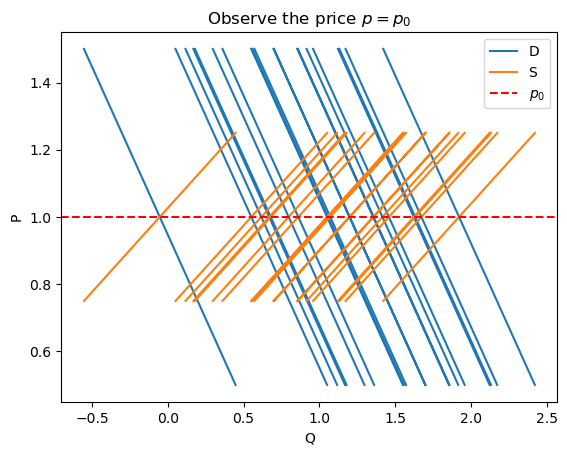

In [52]:
p0 = 1
Udf_plot = Udf['u'].head(20)
Vdf_plot = alpha*p0 + Udf_plot - beta*p0

Q = pd.DataFrame({'min':alpha*(p0+0.5)+Udf_plot,
                   'max':alpha*(p0-0.5)+Udf_plot,
                   'skip':np.nan}) #np.nan is to prevent the connection between head and tail
D = Q.add(-Udf_plot,axis=0)/alpha
S = Q.add(-Vdf_plot,axis=0)/beta

Condition_plot =  pd.DataFrame({'Q':Q.stack(dropna=False),
                                'D':D.stack(dropna=False),
                                'S':S.stack(dropna=False)})

Condition_plot.plot(x='Q')
plt.axhline(y = p0, color = 'r', linestyle = '--', label='$p_0$')
plt.ylabel('P')
plt.title('Observe the price $p = p_0$')
plt.legend()
plt.show()

The calculation is as follows:
$E[q^*(u,v) | q_D(p_0, u)=q_S(p_0, v)]$</br>
The difference between "condition" and "control" is that $p$ is a random variable in this circumstance. Hence we use the correlation between $u,v$ and $p,q$ to get the joint distribution of $p,q$.
$$
[q,p]=[u,v]\pi
$$
This is from the following equations
$$
q-\alpha p=u\\
q-\beta p=v
$$

In [64]:
pi = np.array([[-beta/(alpha-beta),-1/(alpha-beta)],[alpha/(alpha-beta), 1/(alpha-beta)]])
miu1 = miu@pi # mean of the joint distribution
sigma1 = (sigma@pi).T@(sigma@pi) # covariance of the joint distribution
uv = multivariate_normal(mean=miu1, cov=sigma1)

Then the question turned into get the conditional expectation at $p=p_0$.

In [74]:
# we try to realize the result
fp0 = quad(lambda x:uv.pdf([x,p0]),-np.inf,np.inf)[0] # marginal distribution of p at p0
D_condition = quad(lambda x:x*uv.pdf(x)/fp0,-np.inf,np.inf)
D_condition[0]

0.5114083119567586

##### (3) Counterfactual
Observe $(p_0,q_0)$ and change price to $p_1$

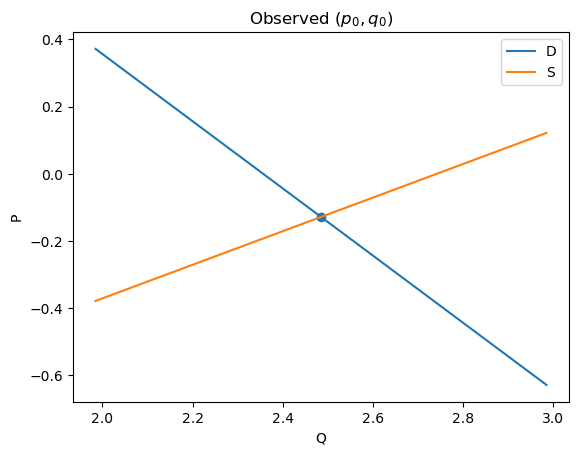

In [79]:
Udf_plot = Udf.head(1)
df_plot = df.head(1)

Q = pd.DataFrame({'min':alpha*(df['p']+0.5)+Udf_plot['u'],
                  'max':alpha*(df['p']-0.5)+Udf_plot['u'],
                  'skip':np.nan}) #np.nan is to prevent the connection between head and tail
D = Q.add(-Udf_plot['u'],axis=0)/alpha
S = Q.add(-Udf_plot['v'],axis=0)/beta

Condition_plot =  pd.DataFrame({'Q':Q.stack(dropna=False),
                                'D':D.stack(dropna=False),
                                'S':S.stack(dropna=False)})

Condition_plot.plot(x='Q')
plt.scatter(df_plot['q'],df_plot['p'])
plt.ylabel('P')
plt.title('Observed $(p_0,q_0)$')
plt.legend()
plt.show()

Now since we observed both $p$ and $q$, $u$ and $v$ is "oberseved" as well.</br>
Hence we could calculate $q_D$ if $p$ turn into $p_1$.</br>
However this won't realize in the reality since $q_D = q_S$ is violated here.

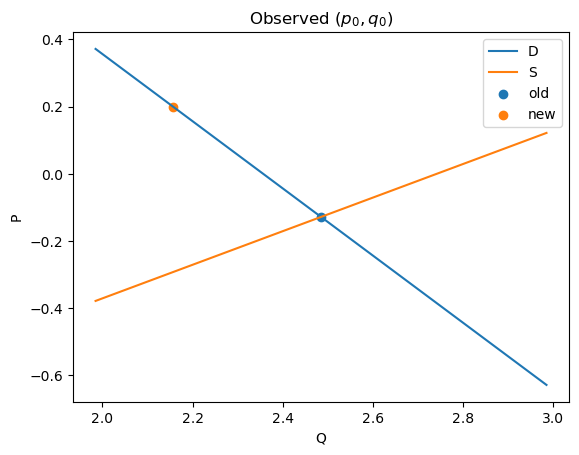

In [82]:
p1 = 0.2 # suppose p1=0.2
q1 = alpha*(p1)+Udf_plot['u'] # calculate q1 directly
Condition_plot.plot(x='Q')
plt.scatter(df_plot['q'],df_plot['p'],label='old')
plt.scatter(q1,p1,label='new')
plt.ylabel('P')
plt.title('Observed $(p_0,q_0)$')
plt.legend()
plt.show()

### Q3. "Plausibly" Exogenous

##### (1) $E(u'Z)=0$
Suppose Z is a $l$ random vector, X is a $k$ random vector.</br>
The Assumption should be (1)(Orthogonality) $E(Z'u)=0$ (2)(Relevance) $E(Z'X)=Q$, $Q$ has full rank. (3) $l\geq k$</br>
Since in the probability world, we have 
$$
y=X\beta+u,E(y-X\beta|Z)=0\\
E(Z'y)-E(Z'X)\beta=0\\
\beta=E(Z'x)^+E(Z'y)
$$
Then in the frequency world, we have
$$
y=Xb+e\\
Z'y-Z'e=Z'Xb\\
b=(Z'X)^+Z'y-(Z'X)^+Z'e\\
$$
If l=k, Z'e=0.</br>
If l>k, we could only make Z'e close to 0

##### (2)
$$
y=X\beta+Z\gamma+u\\
X=Z\pi+v
$$
###### (1)

In [522]:
# data generation process
def linear_dgp(n,beta,gamma,pi):
    # distubance
    U = iid.norm(loc=0,scale=1)
    u = U.rvs(n)
    v = np.exp(u) # make x endogenous
    
    # Z
    l = len(pi)
    l = len(pi)
    zlist = []
    zlabel = ['z'+str(i) for i in range(l)]
    zmu = uniform.rvs(loc=0, scale=10, size=n)
    zsigma = uniform.rvs(loc=2, scale=5, size=n)
    for i in range(l):
        zlist.append(iid.norm(loc=zmu[i],scale=zsigma[i]).rvs(n))
    z = np.c_[zlist].T
    zdf = pd.DataFrame(z,columns=zlabel)
    
    # x,y
    exo = np.c_[z@gamma+u,z@pi+v]
    c = np.array([[1,0],[beta,1]])
    df = pd.DataFrame(exo@c,columns=['y','x'])
    
    df = pd.concat([df,zdf],axis=1) # merge the data
    
    return df[['y']],df[['x']],df[zlabel]

Here we use a 2SLS method to estimate $\beta$ by assuming $\gamma=\gamma_0$.

In [523]:
def plausibly(y,X,Z,gamma0):
    # add constant
    Z['constant'] = 1
    
    # first stage
    pi_hat = np.linalg.solve(Z.T@Z,Z.T@X)
    X_hat = Z@pi_hat
    
    # add constant
    X_hat['constant'] = 1
    Z.drop('constant',axis=1,inplace=True)
    
    # second stage
    y1 = np.array(y).reshape(-1)-np.array(Z@gamma0)
    beta_hat = np.linalg.solve(X_hat.T@X_hat,X_hat.T@y1)
    e = np.array(y).reshape(-1)-np.array(X_hat@beta_hat) # residual
    n = e.shape[0]
    Q = np.linalg.inv(X_hat.T@X_hat)
    s2 = (e.T@e)/n
    beta_std = np.sqrt((s2*Q)[0,0]) # the location (0,0) is based X's place
    
    return beta_hat[0],beta_std

In [524]:
# define the estimator
def plausibly_estimator(n,beta,pi,gamma,gamma0):
    y,X,Z = linear_dgp(n,beta,gamma,pi)
    return plausibly(y,X,Z,gamma0) # return mean and std

In [530]:
n_est = 100
n = 1000
beta = 2
pi = [1.5]
gamma = [0.5] # true gamma
beta_hat = np.zeros((n_est,2))

for gamma0,i in zip(np.linspace(-2,2,n_est),range(n_est)):
    beta_hat[i,0],beta_hat[i,1] = plausibly_estimator(n,beta,pi,gamma,[gamma0]) # get mean and std
    
# upper and lower bound of the confidence interval
upper = beta_hat[:,0]+beta_hat[:,1]*norm.ppf(0.975)
lower = beta_hat[:,0]-beta_hat[:,1]*norm.ppf(0.975)

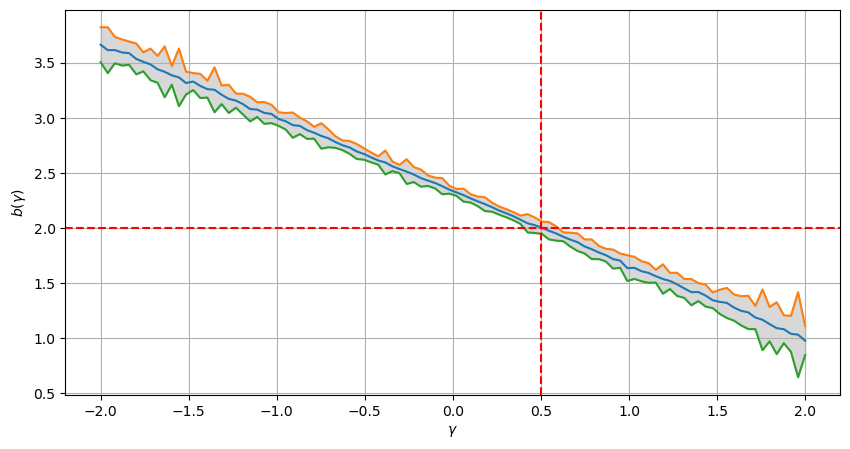

In [531]:
# plot it
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(-2,2,n_est),beta_hat[:,0])
ax.plot(np.linspace(-2,2,n_est),upper)
ax.plot(np.linspace(-2,2,n_est),lower)
ax.fill_between(np.linspace(-2,2,n_est),upper,lower,color='gray', alpha=0.3)

ax.axvline(gamma,c='r',linestyle='--')
ax.axhline(beta,c='r',linestyle='--')

ax.grid()
ax.set_xlabel('$\gamma$')
ax.set_ylabel('$b(\gamma)$')
plt.show()

X axis means $\gamma$ we try when estimate, Y axis estimated $\beta$, and the red line shows the true value of $\gamma$ and $\beta$.</br>
When we pick the right gamma, we would get the proper beta value probably. If not, we could see the bias would get larger as $\gamma$ get away from the true value, and the precision would go down as well.

###### (2)
We suppose the true $\gamma = 0.5$

In [532]:
# get the confidence interval when gamma=0
n = 1000
beta = 2
pi = [1.5]
gamma = [0.5] # true gamma

beta_mean0,beta_std0 = plausibly_estimator(n,beta,pi,gamma,[0])
# 95% confidence level
upper0 = beta_mean0+beta_std0*norm.ppf(0.975)
lower0 = beta_mean0-beta_std0*norm.ppf(0.975)

In [533]:
agree = np.linspace(-2,2,n_est)[(beta_hat[:,0]<upper0) & (beta_hat[:,0]>lower0)]
sup_agree = agree.max()
inf_agree = agree.min()

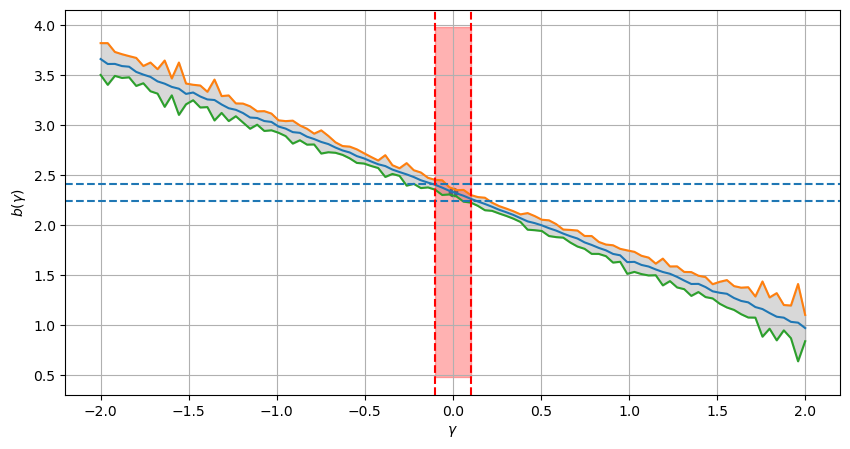

In [534]:
# plot it
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(-2,2,n_est),beta_hat[:,0])
ax.plot(np.linspace(-2,2,n_est),upper)
ax.plot(np.linspace(-2,2,n_est),lower)
ax.fill_between(np.linspace(-2,2,n_est),upper,lower,color='gray', alpha=0.3)

# confidence interval
ax.scatter(0,beta_mean0)
ax.axhline(upper0,linestyle='--')
ax.axhline(lower0,linestyle='--')

# region A
ax.axvline(sup_agree,c='red',linestyle='--')
ax.axvline(inf_agree,c='red',linestyle='--')
ax.fill_betweenx(ax.get_ylim(), inf_agree, sup_agree, color='red', alpha=0.3)

ax.grid()
ax.set_xlabel('$\gamma$')
ax.set_ylabel('$b(\gamma)$')
plt.show()

Here the blue line showes the 95% confidence level interval of $b(0)$, and if $\gamma$ falls into the red region (region A), we might "agree" that $b(\gamma)=b(0)$.

### Q4. Weak Instruments

##### (1) data generation process
$$
y = X\beta+u\\
X = Z\pi+v
$$

In [15]:
def dgp(n,beta,pi):
    # disturbance
    U = iid.norm(loc=0,scale=1)
    u = U.rvs(n)
    v = np.exp(u) # make x endogenous
    
    # z
    l = len(pi)
    zlist = []
    zlabel = ['z'+str(i) for i in range(l)]
    zmu = uniform.rvs(loc=0, scale=10, size=n)
    zsigma = uniform.rvs(loc=2, scale=5, size=n)
    
    # to genenrate a l random vector
    for i in range(l):
        zlist.append(iid.norm(loc=zmu[i],scale=zsigma[i]).rvs(n))
    z = np.c_[zlist].T
    zdf = pd.DataFrame(z,columns=zlabel)
    
    # x,y
    exo = np.c_[u,z@pi+v]
    c = np.array([[1,0],[beta,1]])
    df = pd.DataFrame(exo@c,columns=['y','x'])
    
    df = pd.concat([df,zdf],axis=1) # merge the data
    
    return df[['y']],df[['x']],df[zlabel]

In [16]:
n = 1000
beta = 1
pi = [1]
y0,X0,Z0 = dgp(n,beta,pi)

##### (2) explore IV

(a) define the function

In [17]:
def two_sls(y,X,Z):
    # add constant
    Z['constant'] = 1
    
    # first stage
    pi_hat = np.linalg.solve(Z.T@Z,Z.T@X)
    X_hat = Z@pi_hat
    
    # add constant
    X_hat['constant'] = 1
    
    # second stage
    beta_hat = np.linalg.solve(X_hat.T@X_hat,X_hat.T@y)
    e = np.array(y)-np.array(X_hat@beta_hat) # residual
    n = e.shape[0]
    Q = np.linalg.inv(X_hat.T@X_hat)
    s2 = (e.T@e)/n
    beta_std = np.sqrt((s2*Q)[0,0]) # the location (0,0) is based X's place
    
    
    return beta_hat[0,0],beta_std

(b) estimate when $\beta=\pi=1$ </br>
First we should calculate the confidence interval.

In [18]:
beta_mean,beta_std = two_sls(y0,X0,Z0)
limited_beta = iid.norm(beta,beta_std)

Then we do the Monte Carlo.

In [19]:
# define the estimator
def twosls_esimator(loop,n,beta,pi):
    beta_est = np.zeros((loop,4))
    
    for i in range(loop):
        # generate the data
        y,X,Z = dgp(n,beta,pi)
        
        # estimate the beta
        beta_est[i,0],beta_est[i,1] = two_sls(y,X,Z) # restore the estimated beta and its std
    
    beta_est[:,2] = beta_est[:,0]+beta_est[:,1]*norm.ppf(0.975) # upper bound of interval
    beta_est[:,3] = beta_est[:,0]-beta_est[:,1]*norm.ppf(0.975) # lower bound of interval
        
    bias = beta_est[:,0].mean()-beta
    precision = beta_est[:,0].std()
    power = np.sum((beta_est[:,2]<0) | (beta_est[:,3]>0))/len(beta_est) # if it's out of interval, then reject
    size = 1-power
    
    return beta_est,bias,precision,size,power

In [20]:
loop = 2000
n = 1000
beta = 1
pi = [1]

beta_est,bias,precision,size,power = twosls_esimator(loop,n,beta,pi)
print('Bias:{}'.format(bias))
print('Precision:{}'.format(precision))
print('Size:{}'.format(size))
print('Power:{}'.format(power))

Bias:-0.0002965719415871648
Precision:0.008643120538911366
Size:0.0
Power:1.0


Finally we try to compare the result from inference and Monte Carlo.

In [21]:
np.mean((beta_est[:,0]<limited_beta.isf(.025))&(beta_est[:,0]>limited_beta.isf(.975)))

1.0

Since the result is weird, we draw a PP plot here.

In [40]:
# data for PP
P = [limited_beta.cdf(x) for x in np.sort(beta_est[:,0])]
P_hat = [(beta_est[:,0]<x).mean() for x in np.sort(beta_est[:,0])]

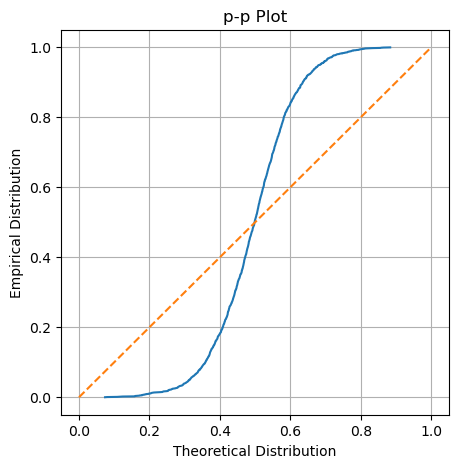

In [45]:
# plot
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(P,P_hat)
ax.plot((0,1),(0,1),linestyle='--')
ax.set_xlabel('Theoretical Distribution')
ax.set_ylabel('Empirical Distribution')
ax.set_title('p-p Plot')
ax.grid()
plt.show()

We could find the empirical distribution has a thin tail than theorical one.

(c) $\pi\in[0,1]$

In [586]:
n_est = 20
loop = 100
n = 1000
beta = 1
pi = np.linspace(0,1,n_est)

# restore the data
bias_est = np.zeros(n_est)
precision_est = np.zeros(n_est)
size_est = np.zeros(n_est)
power_est = np.zeros(n_est)

# estimate with different pi
for i in range(n_est):
    p = [pi[i]]
    beta_est,bias_est[i],precision_est[i],size_est[i],power_est[i] = twosls_esimator(loop,n,beta,p)

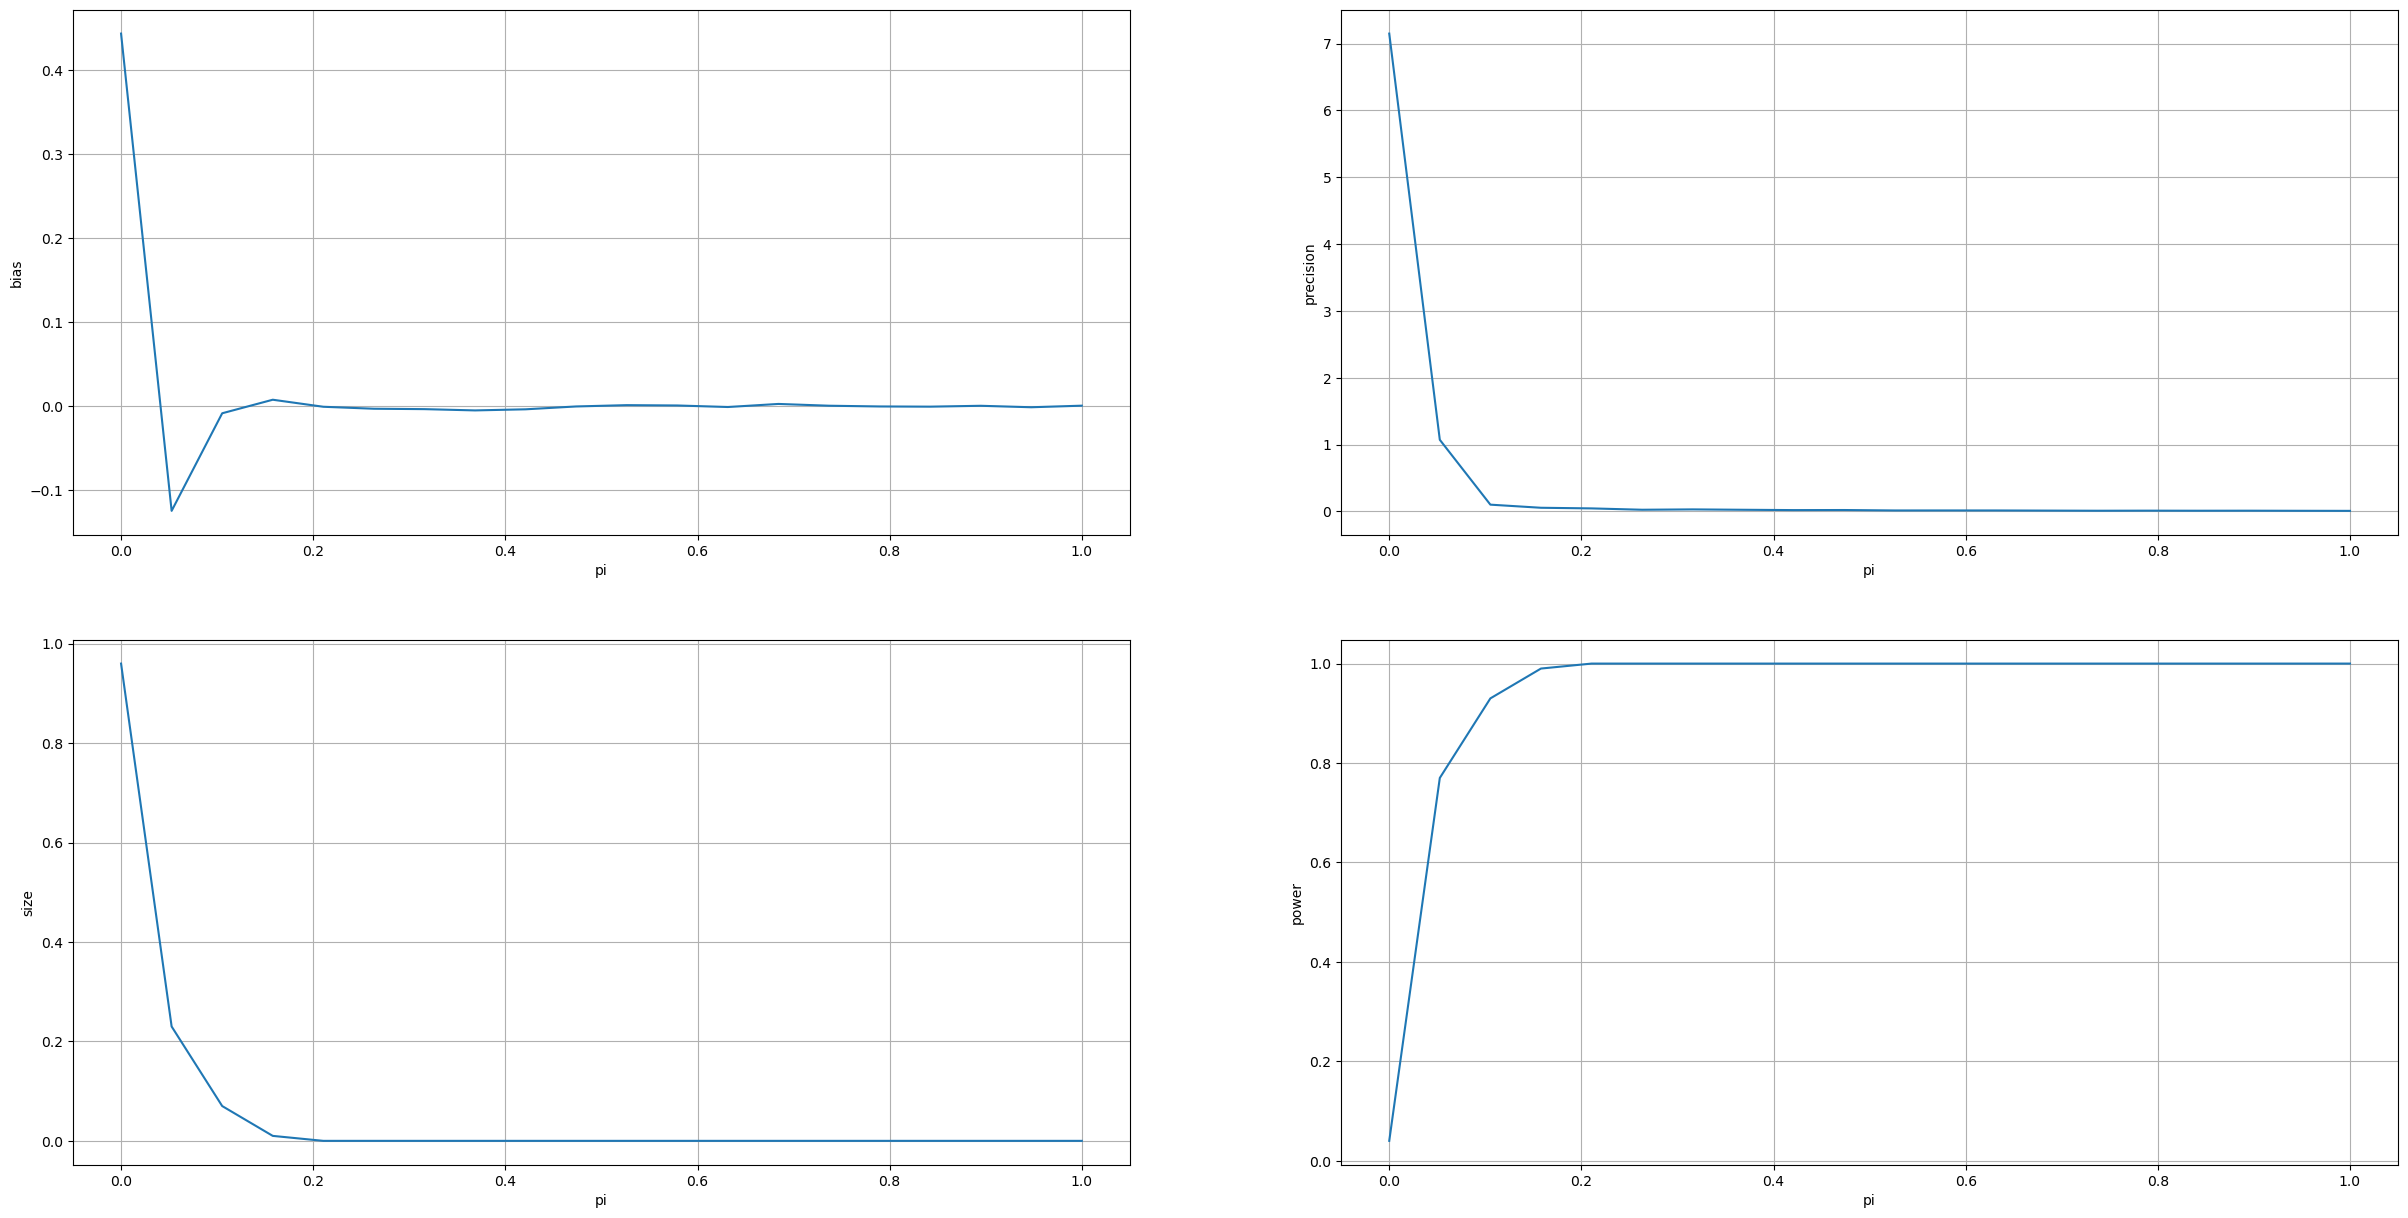

In [587]:
# plot
fig,ax = plt.subplots(2,2,figsize=(30,15))
plot_data = [bias_est,precision_est,size_est,power_est]
plot_name = ['bias','precision','size','power']

for i in range(4):
    row = i//2
    col = i%2
    ax[row,col].plot(pi,plot_data[i])
    ax[row,col].grid()
    ax[row,col].set_xlabel('pi')
    ax[row,col].set_ylabel(plot_name[i])
plt.show()

From the plot we could see the bias increase once $\pi$ approaches 0, also the precison decrease once $\pi$ approaches 0. The Size also increase as $\pi$ approach 0.</br>
Since then, we could tell that 2SLS would be really hard to use and would probably lead a wrong inference if we have a weak instrumental variable.</br>
A weak instrument leads to a biased and imprecise estimation of β, and undermines the size and power of statistical tests. As the strength of the instrument increases (with higher values ofπ), the bias and variance decrease, leading to a more reliable and powerful statistical inference. The results indicate that the reliability of 2SLS estimates is heavily dependent on the strength of the instrument. When the instrument is weak, the 2SLS estimator can produce very unreliable estimates with large standard errors, resulting in a loss of statistical power. 

##### (3) another "weak" iv
(1)

In [594]:
n_est = 10
loop = 100
n = 1000
beta = 1

# restore the data
bias_est = np.zeros(n_est-1)
precision_est = np.zeros(n_est-1)
size_est = np.zeros(n_est-1)
power_est = np.zeros(n_est-1)

# estimate with different pi
for j in range(1,n_est):
    p = [2**(-1*i) for i in range(j)]
    beta_est,bias_est[j-1],precision_est[j-1],size_est[j-1],power_est[j-1] = twosls_esimator(loop,n,beta,pi)

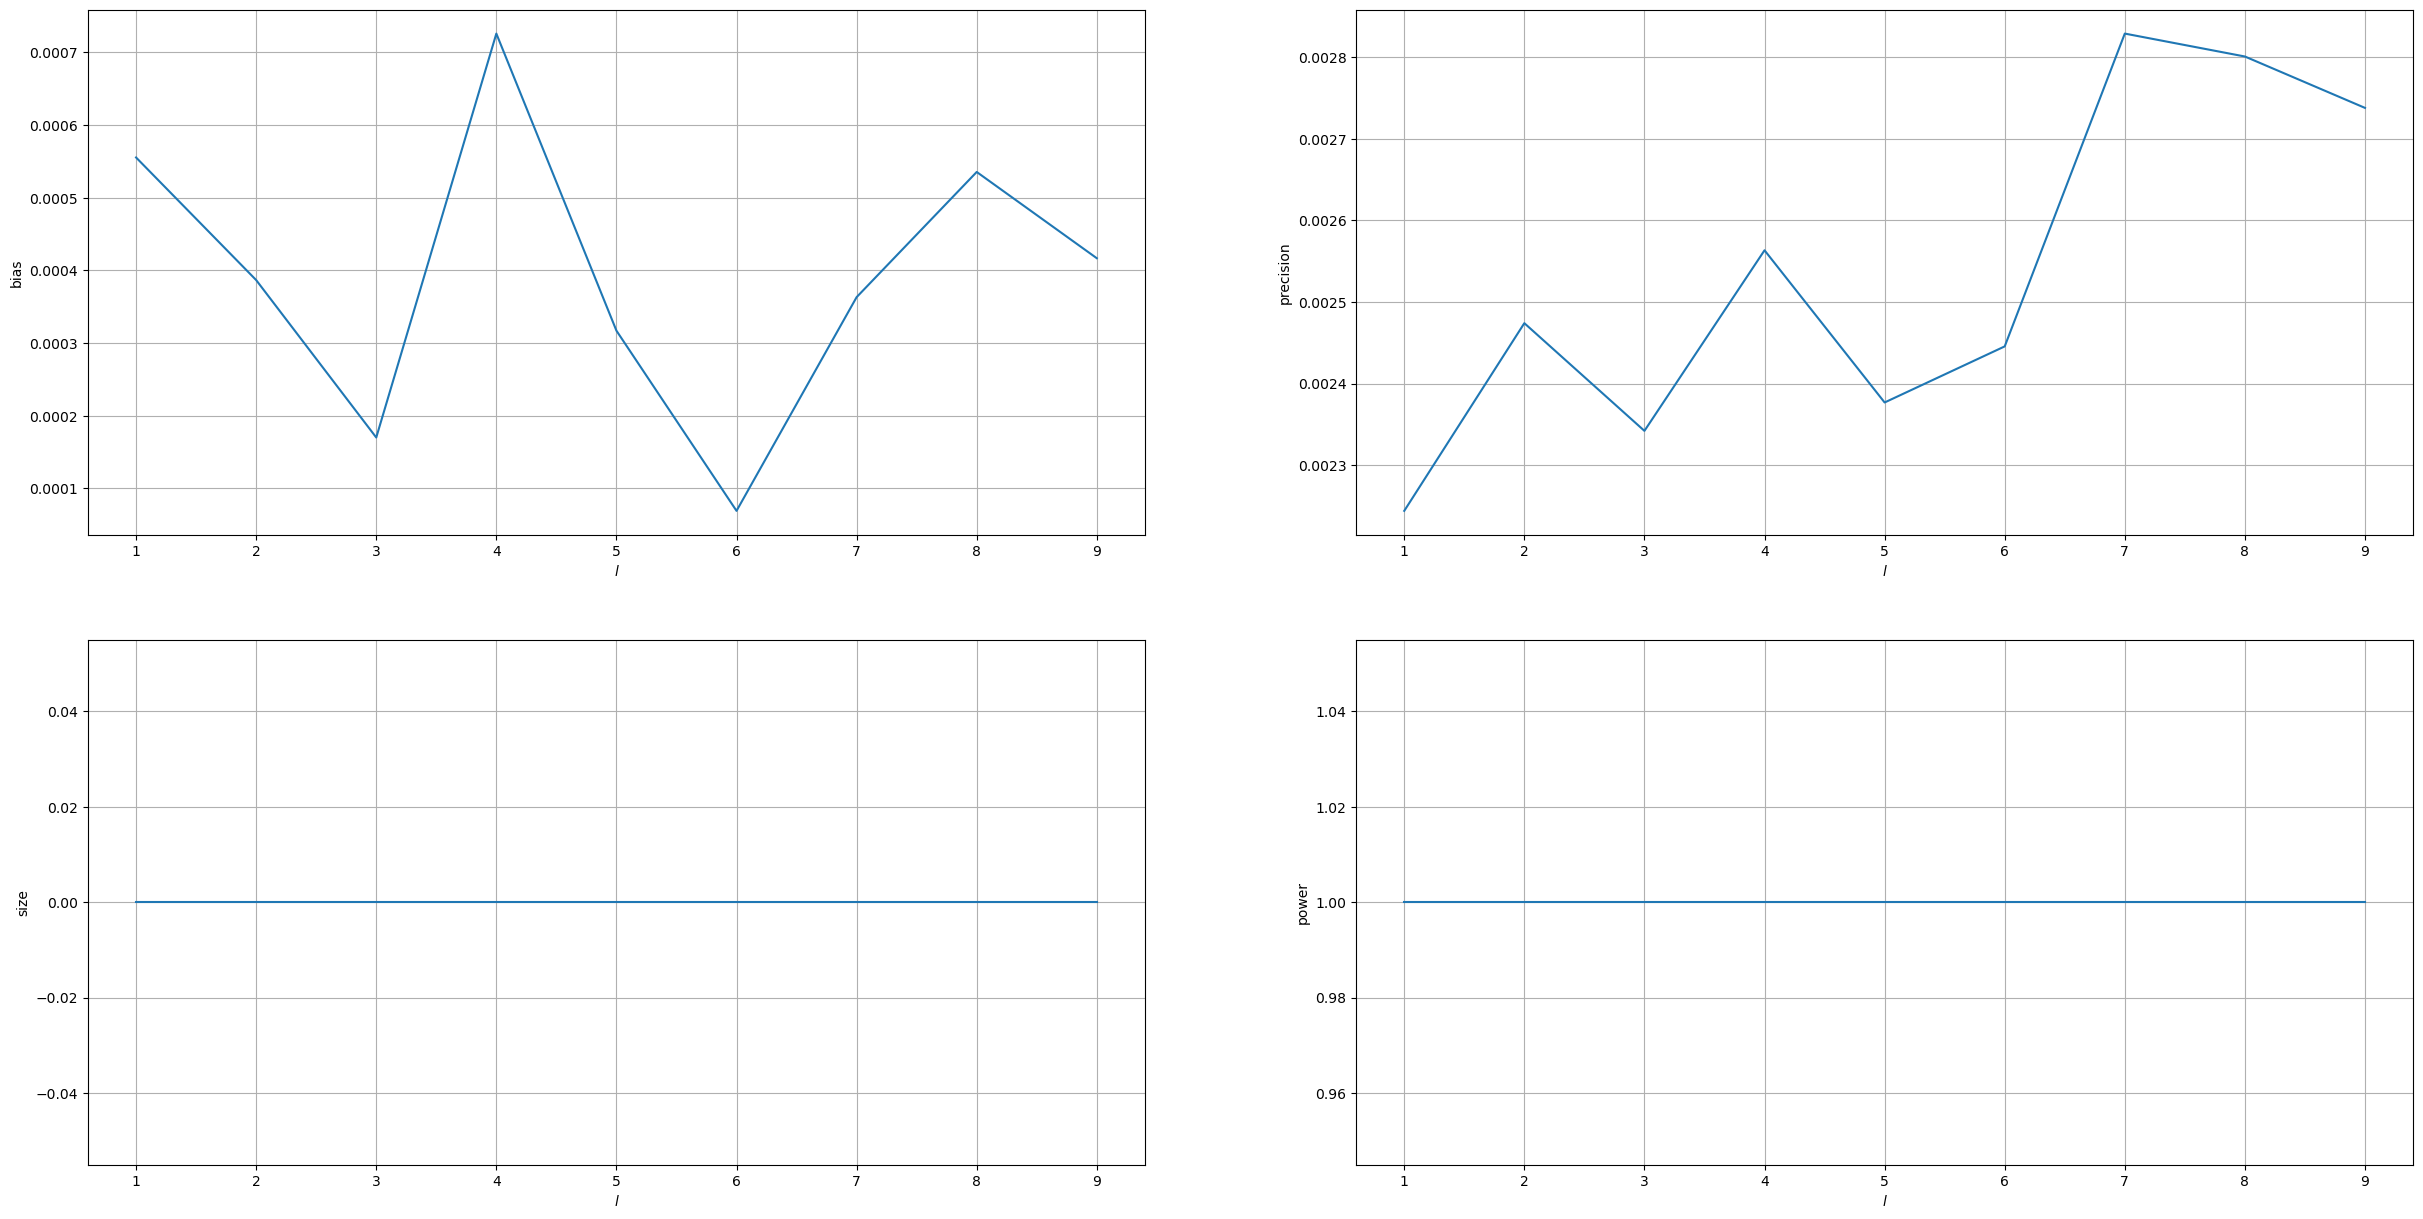

In [595]:
# plot
fig,ax = plt.subplots(2,2,figsize=(30,15))
plot_data = [bias_est,precision_est,size_est,power_est]
plot_name = ['bias','precision','size','power']

for i in range(4):
    row = i//2
    col = i%2
    ax[row,col].plot(range(1,n_est),plot_data[i])
    ax[row,col].grid()
    ax[row,col].set_xlabel('$l$')
    ax[row,col].set_ylabel(plot_name[i])
plt.show()

(2) 
In a typical scenario, adding more instruments can potentially lead to overfitting and a loss of precision. This is because instruments that are weakly correlated with the endogenous variable don't provide much additional information and can inflate the variance of the estimator. Additionally, over-identification can lead to biased estimates if the additional instruments are not valid (i.e., they are correlated with the error term).

However, the results we're seeing indicate that the additional weak instruments are not deteriorating the precision of the estimator. This could be because the instruments, while weak, are still valid. Moreover, in the presence of weak instruments, it is often the case that the 2SLS estimator will have a larger standard error, leading to a smaller t-statistic and thus a lower power for the test.

In this particular case, given that the bias and precision are stable, and assuming that the size and power results are anomalies that need to be investigated further, the choice of the optimal number of instruments (ℓ) would be the minimum number that provides sufficient identification without introducing bias or unnecessary variance. The use of additional instruments beyond this point would not improve the estimates and could potentially lead to other problems such as overfitting or difficulties in the interpretation of the model.

### Q5. A Simple Approach to Inference with Weak Instruments

In [10]:
# the following dgp is same as Q4
def dgp(n,beta,pi):
    # disturbance
    U = iid.norm(loc=0,scale=1)
    u = U.rvs(n)
    v = np.exp(u) # make x endogenous
    
    # z
    l = len(pi)
    zlist = []
    zlabel = ['z'+str(i) for i in range(l)]
    zmu = uniform.rvs(loc=0, scale=10, size=n)
    zsigma = uniform.rvs(loc=2, scale=5, size=n)
    
    # to genenrate a l random vector
    for i in range(l):
        zlist.append(iid.norm(loc=zmu[i],scale=zsigma[i]).rvs(n))
    z = np.c_[zlist].T
    zdf = pd.DataFrame(z,columns=zlabel)
    
    # x,y
    exo = np.c_[u,z@pi+v]
    c = np.array([[1,0],[beta,1]])
    df = pd.DataFrame(exo@c,columns=['y','x'])
    
    df = pd.concat([df,zdf],axis=1) # merge the data
    
    return df[['y']],df[['x']],df[zlabel]

(1) test whether gamma is 0

In [11]:
def CH(y,x,Z,beta0):
    endo = y-beta0*x # left hand side are endogenous variables
    gamma_hat = np.linalg.solve(Z.T@Z,Z.T@endo)
    w = endo-Z@gamma_hat
    
    # F test(fitted)
    SSRu = w.T@w
    SSRr = endo.T@endo
    n = Z.shape[0]
    k = Z.shape[1]
    F = ((SSRr-SSRu)/k)/(SSRu/(n-k))
    pvalue = 1-f.cdf(F,k,n-k)

    return pvalue[0,0]

(2) Use optimization to inference

In [12]:
def CHestimator(loop,n,beta,pi):
    beta_est = np.zeros(loop)
    
    for i in range(loop):
        # generate data, beta=pi=1
        y,x,Z = dgp(n,beta,pi)
        y = np.array(y)
        x = np.array(x)
        Z['constant'] = 1
        Z = np.array(Z)
    
        # set the target function for the optimization
        def targetCH(beta0,y=y,x=x,Z=Z):
            return -1*CH(y,x,Z,beta0)
        
        beta0_hat = minimize(targetCH,0,method='Powell')
        beta_est[i] = beta0_hat.x[0]
        bias = beta_est.mean()-beta
        precision = beta_est.std()
        
    return bias,precision,beta_est

The bias of estimated beta:-0.0001
The precision of estimated beta:0.0045


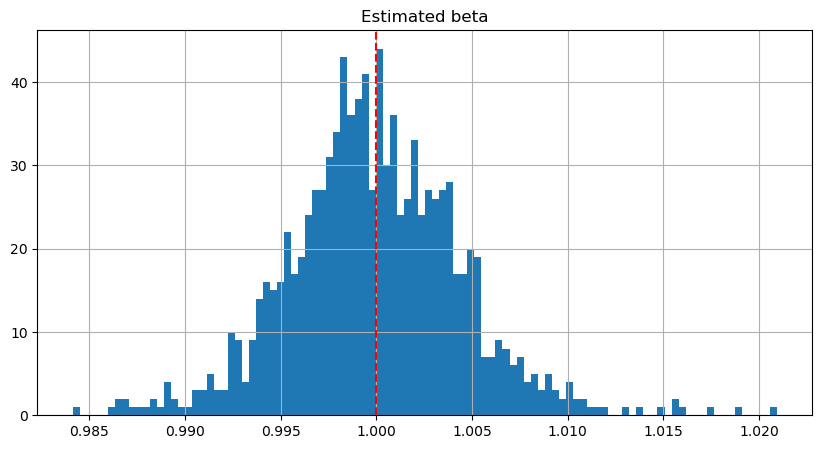

In [291]:
# estimate beta for 1000 times
loop = 1000
n = 1000
beta = 1
pi = [1]
bias,precision,beta_hat = CHestimator(loop,n,beta,pi)

# evaluate
beta_hat_mean = beta_hat.mean()
beta_hat_std = beta_hat.std()
print('The bias of estimated beta:{:.4f}'.format(bias))
print('The precision of estimated beta:{:.4f}'.format(precision))

# plot
fig,ax = plt.subplots(figsize=(10,5))

ax.hist(beta_hat,bins=100)
ax.axvline(x=1, color='r', linestyle='--')
ax.grid()
ax.set_title('Estimated beta')

plt.show()

From the result above, we could see both bias and precision are nearly 0, showing its capicity in estimate.

(3) 95% confidence interval

Lower bound of 95% confidence interval is 0.9910
Upper bound of 95% confidence interval is 1.0088


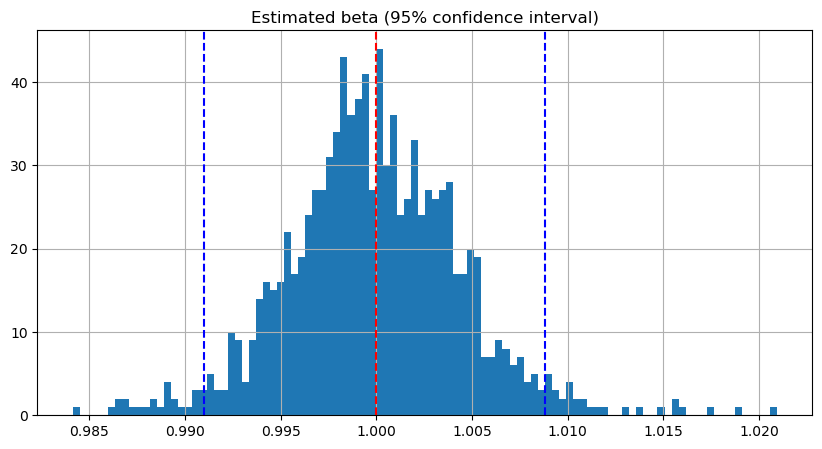

In [292]:
upper = beta_hat_mean+beta_hat_std*norm.ppf(0.975)
lower = beta_hat_mean-beta_hat_std*norm.ppf(0.975)
print('Lower bound of 95% confidence interval is {:.4f}'.format(lower))
print('Upper bound of 95% confidence interval is {:.4f}'.format(upper))

# plot
fig,ax = plt.subplots(figsize=(10,5))

ax.hist(beta_hat,bins=100)
ax.axvline(x=1, color='r', linestyle='--')
ax.axvline(x=upper, color='b', linestyle='--')
ax.axvline(x=lower, color='b', linestyle='--')
ax.grid()
ax.set_title('Estimated beta (95% confidence interval)')

plt.show()

Compared CH method and 2SLS, the result are quite similar under this condition.

(4) When $\pi$ goes from 1 to 0

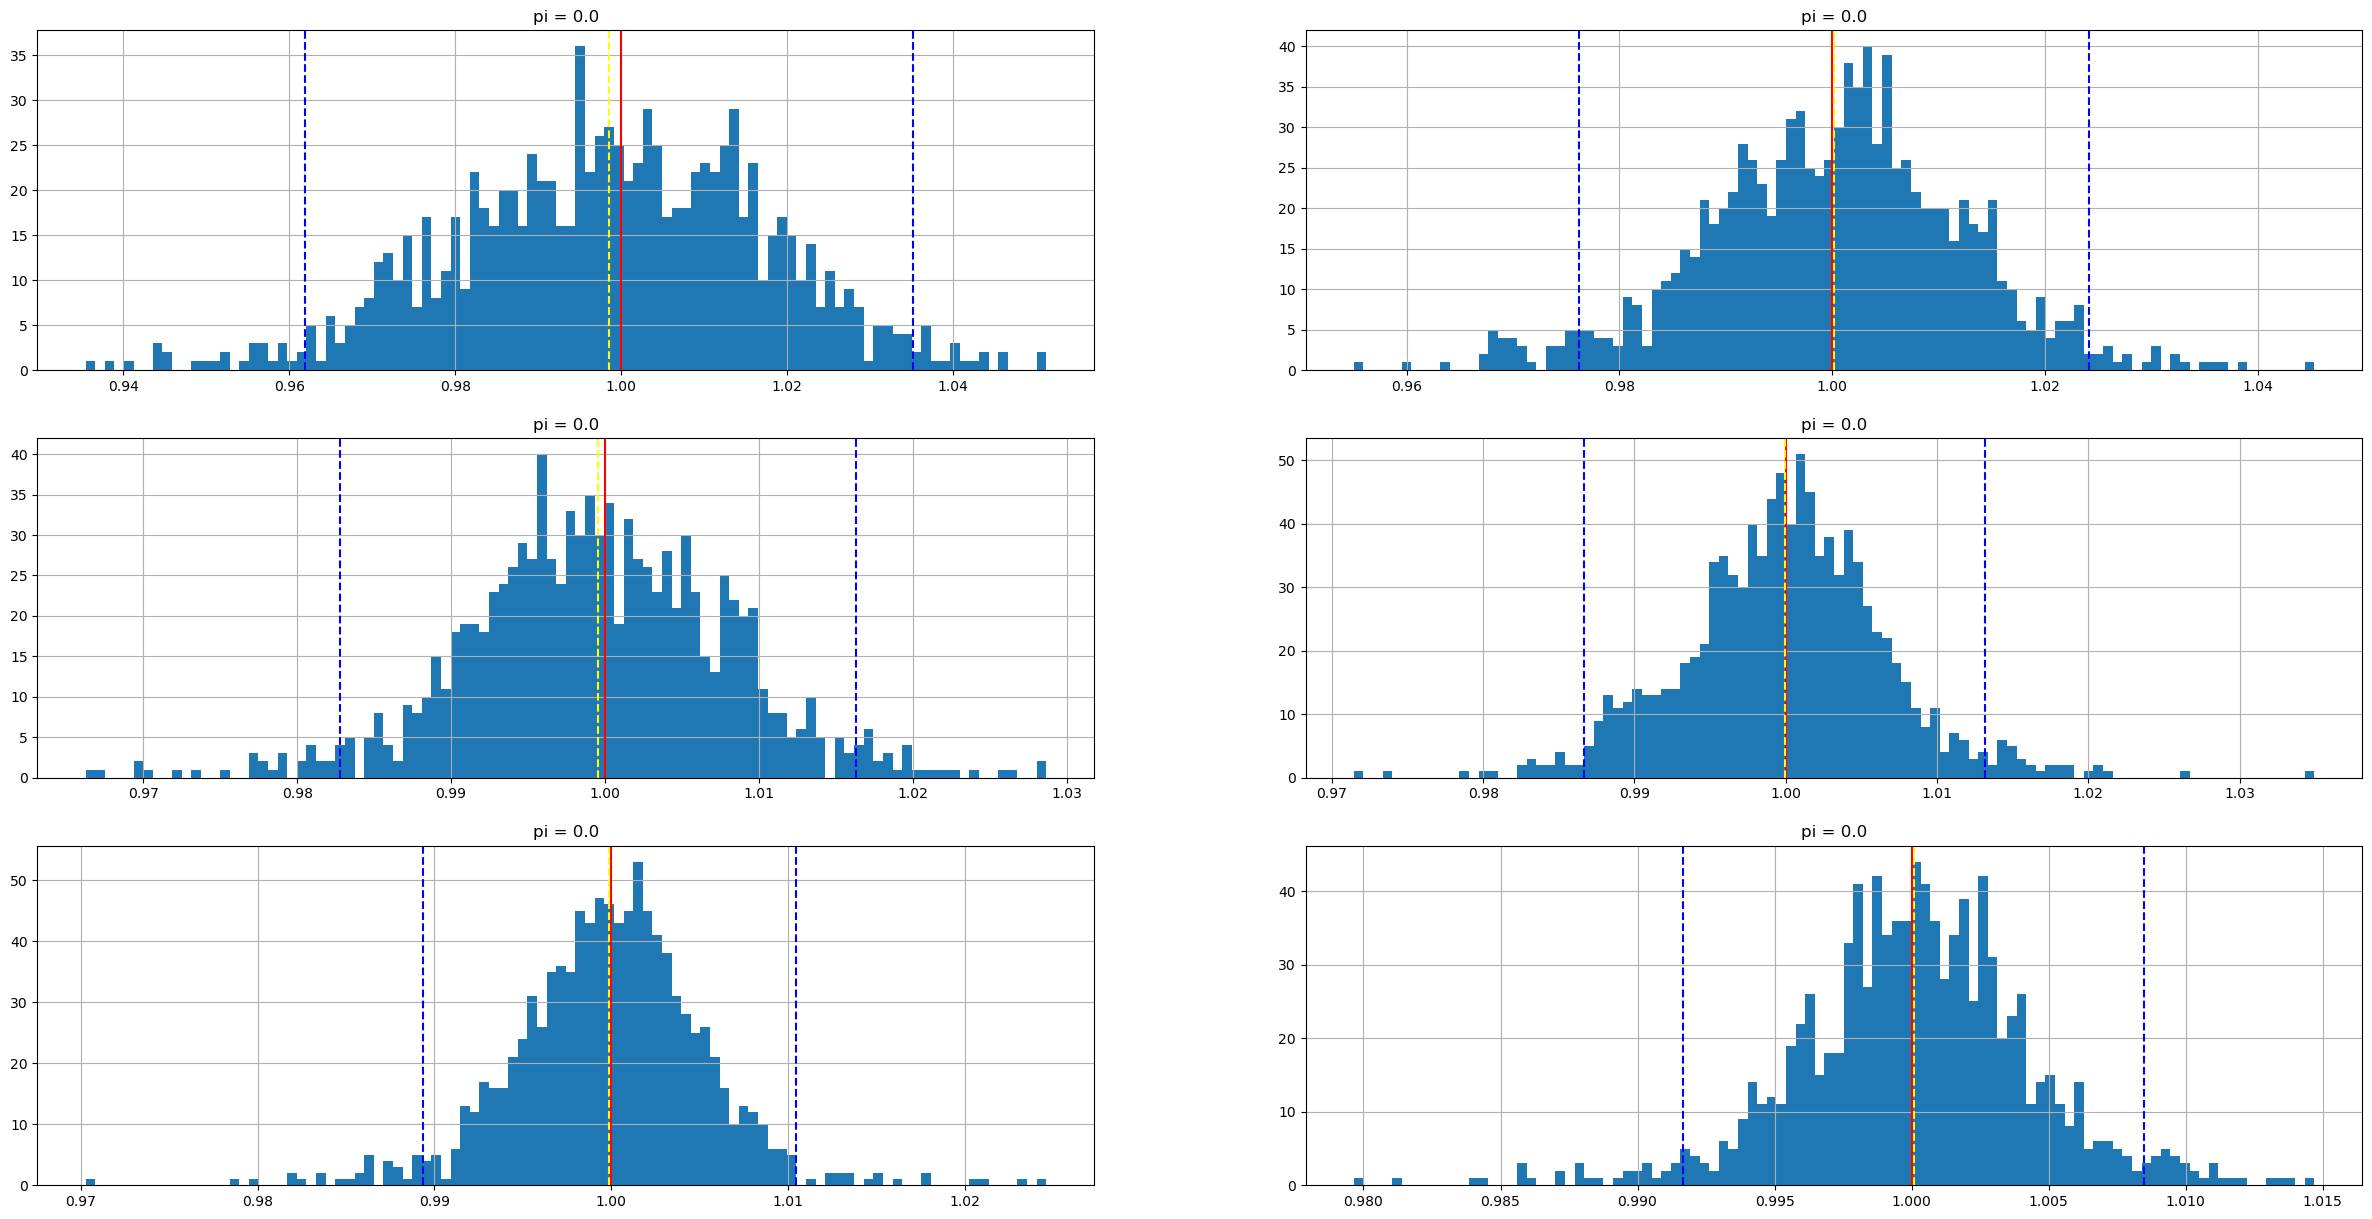

In [297]:
# plot
fig,ax = plt.subplots(3,2,figsize=(30,15))
n_est = 6
bias_est = np.zeros(n_est)
precision_est = np.zeros(n_est)
pi = np.linspace(0,1,n_est)

for i in range(n_est):
    row = i//2
    col = i%2
    n = 1000
    beta = 1
    p = [pi[i]]
    bias_est[i],precision_est[i],beta_hat = CHestimator(1000,n,beta,p)
    
    beta_hat_mean = beta_hat.mean()
    beta_hat_std = beta_hat.std()
    upper = beta_hat_mean+beta_hat_std*norm.ppf(0.975)
    lower = beta_hat_mean-beta_hat_std*norm.ppf(0.975)
    
    ax[row,col].hist(beta_hat,bins=100)
    ax[row,col].axvline(x=1, color='r', linestyle='-')
    ax[row,col].axvline(x=beta_hat_mean, color='yellow', linestyle='--')
    ax[row,col].axvline(x=upper, color='b', linestyle='--')
    ax[row,col].axvline(x=lower, color='b', linestyle='--')
    ax[row,col].grid()
    ax[row,col].set_title('pi = {}'.format(pi[0]))

plt.show()

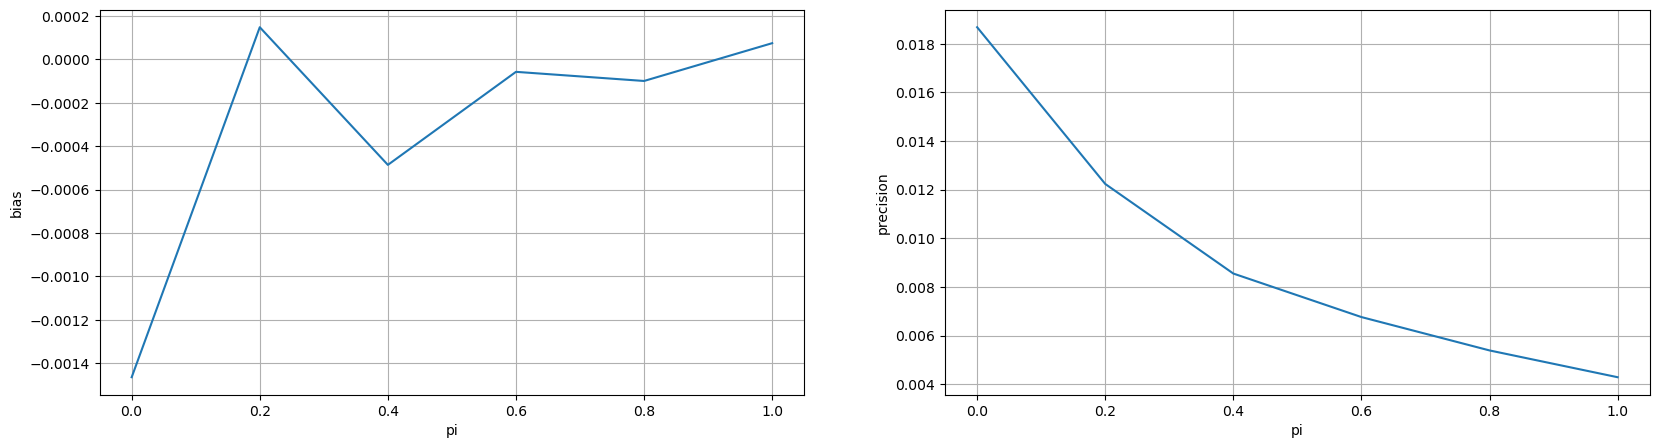

In [299]:
# plot
fig,ax = plt.subplots(1,2,figsize=(20,5))
plot_data = [bias_est,precision_est]
plot_name = ['bias','precision']

for i in range(2):
    ax[i].plot(pi,plot_data[i])
    ax[i].grid()
    ax[i].set_xlabel('pi')
    ax[i].set_ylabel(plot_name[i])
plt.show()

Compared to 2SLS, the bias is at a "0.001" level while 2SLS is at a "0.1" level, while here the precision is at a "0.01" level compared to 2SLS's "1" level. The CH method performs much better with a weak instrument variables.

(5) $l$ goes larger

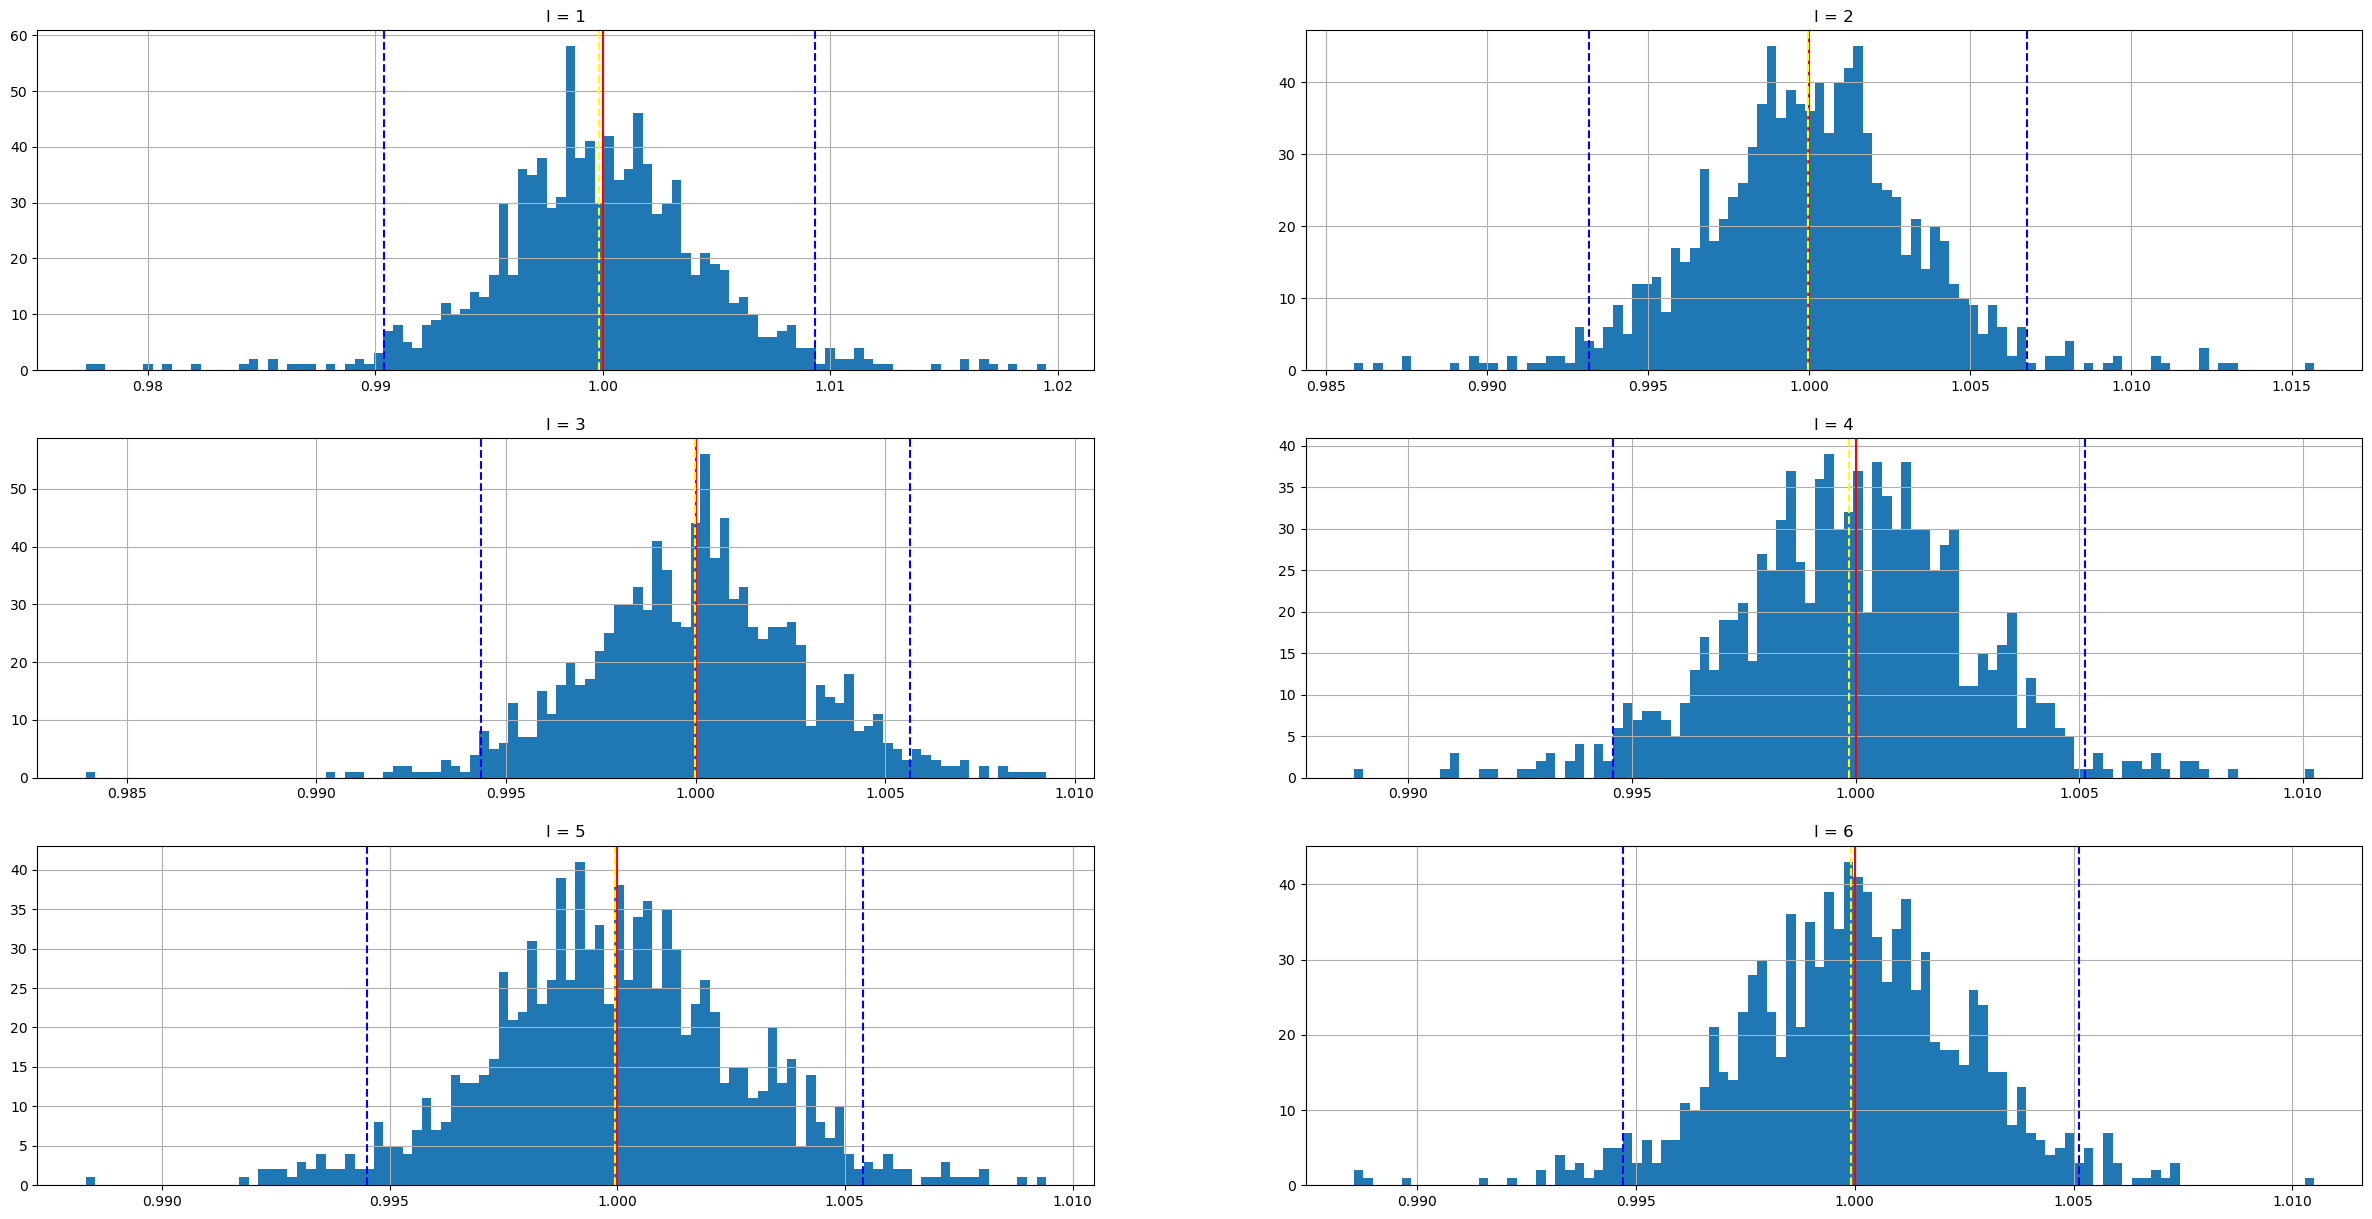

In [13]:
# plot
fig,ax = plt.subplots(3,2,figsize=(30,15))
l = 6
bias_est = np.zeros(l)
precision_est = np.zeros(l)

for i in range(l):
    row = i//2
    col = i%2
    n = 1000
    beta = 1
    pi = [1/(2**j) for j in range(i+1)]
    bias_est[i],precision_est[i],beta_hat = CHestimator(1000,n,beta,pi)
    
    beta_hat_mean = beta_hat.mean()
    beta_hat_std = beta_hat.std()
    upper = beta_hat_mean+beta_hat_std*norm.ppf(0.975)
    lower = beta_hat_mean-beta_hat_std*norm.ppf(0.975)
    
    ax[row,col].hist(beta_hat,bins=100)
    ax[row,col].axvline(x=1, color='r', linestyle='-')
    ax[row,col].axvline(x=beta_hat_mean, color='yellow', linestyle='--')
    ax[row,col].axvline(x=upper, color='b', linestyle='--')
    ax[row,col].axvline(x=lower, color='b', linestyle='--')
    ax[row,col].grid()
    ax[row,col].set_title('l = {}'.format(len(pi)))

plt.show()

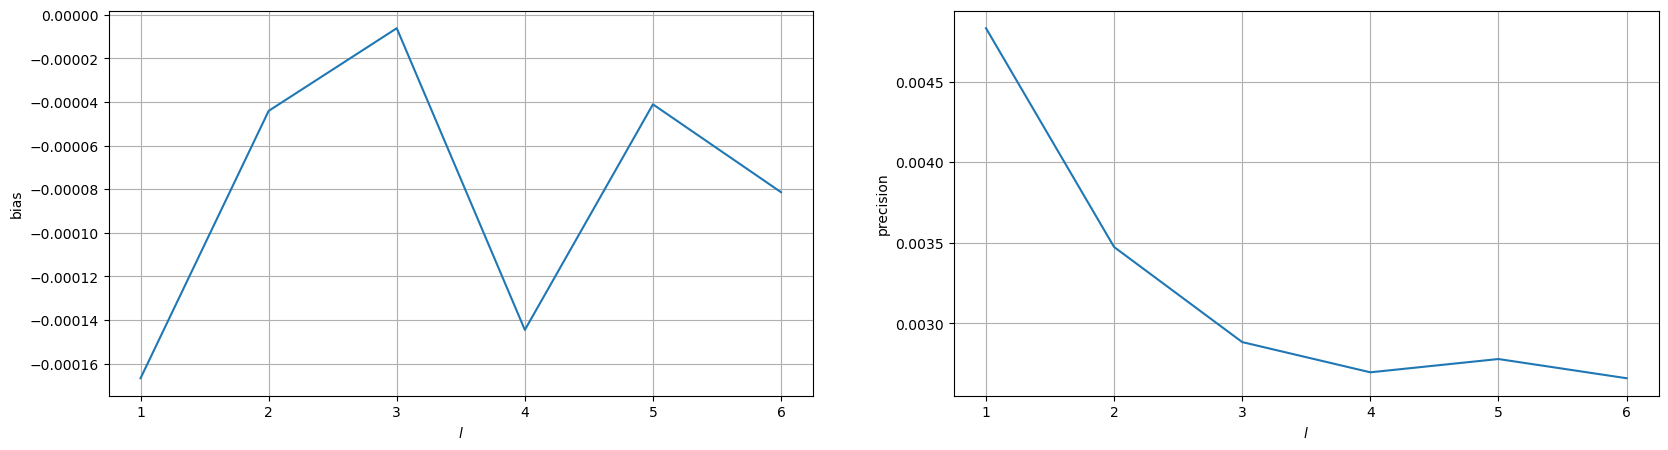

In [14]:
# plot
fig,ax = plt.subplots(1,2,figsize=(20,5))
plot_data = [bias_est,precision_est]
plot_name = ['bias','precision']

for i in range(2):
    ax[i].plot(range(1,l+1),plot_data[i])
    ax[i].grid()
    ax[i].set_xlabel('$l$')
    ax[i].set_ylabel(plot_name[i])
plt.show()

Compared to 2SLS, the bias is still much better as its bias is only half of 2SLS's. However, its precision is larger than 2SLS. However, their difference in precision decrease as $l$ increases.

### Q6. Angrist Krueger (1991)
##### (1)
Suppose educational attainment is $x$, quarter of birth is $z$, and $u$ means the disturbance. Then we have the following conditions:</br>
(1)(Orthogonality) $E(z'u)=0$ (2)(Relevance) $E(z'x)=Q$, $Q$ has full rank</br>
First, since the birth date is totally random, especially those date between two quarters which are totally random, so the first assumption is satisfied.</br>
Then, because of the compulsory school attendance, the quarter of birth is related to educational attainment, so the second assumption is satisfied.</br>

##### (2) Table V

In [4]:
# import the data
dtafile = 'angrist-krueger91.dta'
df = pd.read_stata(dtafile)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329509 entries, 0 to 329508
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ageq     329509 non-null  float32
 1   edu      329509 non-null  int8   
 2   logwage  329509 non-null  float32
 3   married  329509 non-null  int8   
 4   state    329509 non-null  int8   
 5   qob      329509 non-null  int8   
 6   black    329509 non-null  int8   
 7   smsa     329509 non-null  int8   
 8   yob      329509 non-null  int16  
 9   region   329509 non-null  float32
dtypes: float32(3), int16(1), int8(6)
memory usage: 6.3 MB


,ageq,edu,logwage,married,state,qob,black,smsa,yob,region
0,47.00,12,6.245846,1,1,1,1,1,1933,0.0
1,46.25,12,5.847161,1,48,4,1,1,1933,0.0
2,50.00,12,6.645516,1,2,1,1,1,1930,0.0
3,47.00,16,6.706133,1,22,1,1,1,1933,0.0
4,42.25,14,6.357876,1,42,4,1,1,1937,0.0


In [2]:
#Create year of birth dummies
dummies = pd.get_dummies(df['yob'])
df = pd.concat([df, dummies], axis=1)

#Create age squared variable
df['ageqsq'] = df['ageq']**2

#Create region dummies
dummiesregion = pd.get_dummies(df['region'])
df = pd.concat([df, dummiesregion], axis=1)

#Create qob dummies
dummiesqob = pd.get_dummies(df['qob'])
df = pd.concat([df, dummiesqob], axis=1)

#Convert boolean variables to integers
df.replace({False: 0, True: 1}, inplace=True)

/tmp/ipykernel_73/2771142275.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({False: 0, True: 1}, inplace=True)


The following is the OLS part.

In [4]:
#Table 5

#Specification 1
ols_model1 = sm.OLS(df['logwage'], df[['edu'] + list(dummies.columns)]).fit()
print(ols_model1.summary())

#Specification 3
ols_model3 = sm.OLS(df['logwage'], df[['edu'] + list(dummies.columns) + ['ageq'] + ['ageqsq']]).fit()
print(ols_model3.summary())

#Specification 5
ols_model5 = sm.OLS(df['logwage'], df[['edu'] + ['black'] + ['smsa'] + ['married'] + list(dummies.columns) + list(dummiesregion.columns) ]).fit()
print(ols_model5.summary())

#Specification 7
ols_model7 = sm.OLS(df['logwage'], df[['edu'] + ['black'] + ['smsa'] + ['married'] + list(dummies.columns) + list(dummiesregion.columns)  + ['ageq'] + ['ageqsq']]).fit()
print(ols_model7.summary())

                            OLS Regression Results                            
Dep. Variable:                logwage   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     4397.
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:35:12   Log-Likelihood:            -3.1926e+05
No. Observations:              329509   AIC:                         6.385e+05
Df Residuals:                  329498   BIC:                         6.387e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
edu            0.0711      0.000    209.674      0.0

In [6]:
#Create instrument
qobyear_interaction_terms = pd.DataFrame()
for quarter_col in dummiesqob.columns:
    for year_col in dummies.columns:
        col_name = f'{quarter_col}_{year_col}'
        qobyear_interaction_terms[col_name] = dummiesqob[quarter_col] * dummies[year_col]

df = pd.concat([df, qobyear_interaction_terms], axis=1)

In [7]:
#Convert boolean variables to integers
df.replace({False: 0, True: 1}, inplace=True)

df.info()

/tmp/ipykernel_73/1148687731.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({False: 0, True: 1}, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329509 entries, 0 to 329508
Data columns (total 74 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ageq     329509 non-null  float32
 1   edu      329509 non-null  int8   
 2   logwage  329509 non-null  float32
 3   married  329509 non-null  int8   
 4   state    329509 non-null  int8   
 5   qob      329509 non-null  int8   
 6   black    329509 non-null  int8   
 7   smsa     329509 non-null  int8   
 8   yob      329509 non-null  int16  
 9   region   329509 non-null  float32
 10  1930     329509 non-null  int64  
 11  1931     329509 non-null  int64  
 12  1932     329509 non-null  int64  
 13  1933     329509 non-null  int64  
 14  1934     329509 non-null  int64  
 15  1935     329509 non-null  int64  
 16  1936     329509 non-null  int64  
 17  1937     329509 non-null  int64  
 18  1938     329509 non-null  int64  
 19  1939     329509 non-null  int64  
 20  ageqsq   329509 non-null  

In [8]:
from statsmodels.sandbox.regression.gmm import IV2SLS

dummiesregion1 = pd.get_dummies(df['region'])
df = pd.concat([df, dummiesregion1], axis=1)
df.replace({False: 0, True: 1}, inplace=True)

df.info


/tmp/ipykernel_73/1838335172.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({False: 0, True: 1}, inplace=True)


<bound method DataFrame.info of          ageq  edu   logwage  married  state  qob  black  smsa   yob  region  \
0       47.00   12  6.245846        1      1    1      1     1  1933     0.0   
1       46.25   12  5.847161        1     48    4      1     1  1933     0.0   
2       50.00   12  6.645516        1      2    1      1     1  1930     0.0   
3       47.00   16  6.706133        1     22    1      1     1  1933     0.0   
4       42.25   14  6.357876        1     42    4      1     1  1937     0.0   
...       ...  ...       ...      ...    ...  ...    ...   ...   ...     ...   
329504  42.50   10  4.583833        1     26    3      1     1  1937     4.0   
329505  42.00   12  5.784210        1     22    1      1     1  1938     4.0   
329506  41.00   12  5.707302        1     48    1      1     1  1939     4.0   
329507  47.25   12  5.952494        1     42    4      1     1  1932     4.0   
329508  48.50   13  6.047781        1     20    3      1     1  1931     4.0   

       

The following is the TSLS part.

In [9]:
#Table 5

#Specification 2
first_stage_model2 = IV2SLS(df['edu'], df[['edu'] + list(dummies.columns)], df[list(qobyear_interaction_terms.columns)]).fit()
predicted_values2 = first_stage_model2.predict()

second_stage_model2 = IV2SLS(df['logwage'], df[['edu'] + list(dummies.columns)], df[list(qobyear_interaction_terms.columns)]).fit()

print(second_stage_model2.summary())

#Specification 4
first_stage_model4 = IV2SLS(df['edu'], df[['edu'] + list(dummies.columns) + ['ageq'] + ['ageqsq']], df[list(qobyear_interaction_terms.columns)]).fit()
predicted_values4 = first_stage_model4.predict()

second_stage_model4 = IV2SLS(df['logwage'], df[['edu'] + list(dummies.columns)  + ['ageq'] + ['ageqsq']], df[list(qobyear_interaction_terms.columns)]).fit()

print(second_stage_model4.summary())

#Specification 6
first_stage_model6 = IV2SLS(df['edu'], df.iloc[:, [1, 3, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29]], df[list(qobyear_interaction_terms.columns)]).fit()
predicted_values6 = first_stage_model6.predict()

second_stage_model6 = IV2SLS(df['logwage'], df.iloc[:, [1, 3, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29]], df[list(qobyear_interaction_terms.columns)]).fit()

print(second_stage_model6.summary())

#Specification 8
first_stage_model8 = IV2SLS(df['edu'], df.iloc[:, [0, 1, 3, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]], df[list(qobyear_interaction_terms.columns)]).fit()
predicted_values8 = first_stage_model8.predict()

second_stage_model8 = IV2SLS(df['logwage'], df.iloc[:, [0, 1, 3, 6, 7, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29]], df[list(qobyear_interaction_terms.columns)]).fit()

print(second_stage_model8.summary())

                          IV2SLS Regression Results                           
Dep. Variable:                logwage   R-squared:                       0.110
Model:                         IV2SLS   Adj. R-squared:                  0.110
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Wed, 17 Apr 2024                                         
Time:                        18:35:28                                         
No. Observations:              329509                                         
Df Residuals:                  329498                                         
Df Model:                          10                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
edu            0.0891      0.016      5.532      0.0

/srv/conda/lib/python3.9/site-packages/statsmodels/sandbox/regression/gmm.py:290: RuntimeWarning: invalid value encountered in sqrt
  condno = np.sqrt(eigvals[-1]/eigvals[0])
/srv/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


                          IV2SLS Regression Results                           
Dep. Variable:                logwage   R-squared:                      -0.082
Model:                         IV2SLS   Adj. R-squared:                 -0.082
Method:                     Two Stage   F-statistic:                       nan
                        Least Squares   Prob (F-statistic):                nan
Date:                Wed, 17 Apr 2024                                         
Time:                        18:35:40                                         
No. Observations:              329509                                         
Df Residuals:                  329486                                         
Df Model:                          22                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
edu            0.0680      0.024      2.859      0.0

/srv/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1854: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


In [10]:
# Construct CIs for 2SLS specifications
ci2 = second_stage_model2.conf_int(alpha=0.05)  # specification 2
ci4 = second_stage_model4.conf_int(alpha=0.05)  # specification 4
ci6 = second_stage_model6.conf_int(alpha=0.05)  # specification 6
ci8 = second_stage_model8.conf_int(alpha=0.05)  # specification 8

# Print the confidence intervals
print(ci2)
print(ci4)
print(ci6)
print(ci8)

             0         1
edu   0.057540  0.120691
1930  4.399392  5.186062
1931  4.386139  5.181552
1932  4.375771  5.173622
1933  4.370217  5.171646
1934  4.365218  5.168660
1935  4.350177  5.157622
1936  4.348408  5.159522
1937  4.340386  5.155433
1938  4.335947  5.156416
1939  4.322726  5.145673
               0         1
edu     0.019228  0.132771
1930    4.137808  9.633298
1931    4.123203  9.636818
1932    4.108386  9.634078
1933    4.099927  9.632891
1934    4.091858  9.626820
1935    4.075928  9.608111
1936    4.073935  9.598221
1937    4.066737  9.577932
1938    4.065002  9.558294
1939    4.053506  9.523236
ageq   -0.206455  0.046220
ageqsq -0.000608  0.002270
                    0             1
edu          0.021377      0.114542
married     -0.536446      1.509055
black       -1.417774      0.595177
smsa        -0.030423      1.597200
1930              NaN           NaN
1931              NaN           NaN
1932              NaN           NaN
1933              NaN           Na

In [11]:
# restore the data
df.to_csv('angristandkrueger.csv')